In [2]:
#fixing some errors in the code
import subprocess

# Install the pyarrow package
subprocess.run(["pip", "install", "pyarrow"])

CompletedProcess(args=['pip', 'install', 'pyarrow'], returncode=0)

In [3]:
#extracting column names from CSV
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('4.csv')

# Extract the column titles
column_titles = df.columns.tolist()

# Print the column titles
print(column_titles)

['Issue Type', 'Summary', 'Status', 'Updated', 'Created', 'Priority', 'Issue key', 'Issue id', 'Parent id', 'Reporter', 'Assignee', 'Resolved', 'Time Spent']


In [4]:
#print key statistics as a table
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('4.csv')
df['Resolved'] = pd.to_datetime(df['Resolved'])
df['Created'] = pd.to_datetime(df['Created'])
df['Time Difference (days)'] = (df['Resolved'] - df['Created']).dt.total_seconds() / 86400
grouped = df.groupby('Issue Type')

stats_dict = {}
for name, group in grouped:
    time_diff = group['Time Difference (days)']
    mean = time_diff.mean()
    percentile_98 = np.percentile(time_diff, 98)
    percentile_75 = np.percentile(time_diff, 75)
    ratio_98_mean = percentile_98 / mean if mean != 0 else np.nan
    tail_type = 'Thin Tail' if ratio_98_mean <= 5.6 else 'Fat Tail'
    mode = time_diff.mode()[0] if not time_diff.mode().empty else np.nan
    ratio_98_mode = percentile_98 / mode if mode != 0 else np.nan
    second_check = 'Thin Tail' if ratio_98_mode <= 16 else 'Not Thin Tail'
    stats_dict[name] = {
        'Sample Size': group.shape[0],
        'min': time_diff.min(),
        'max': time_diff.max(),
        'mode': mode,
        'median': time_diff.median(),
        'mean': mean,
        '75th_percentile': percentile_75,
        '85th_percentile': np.percentile(time_diff, 85),
        '98th_percentile': percentile_98,
        '98th_percentile/Mean Ratio': ratio_98_mean,
        'Tail Type': tail_type
    }
    if tail_type == 'Thin Tail':
        stats_dict[name]['98th_percentile/Mode Ratio'] = ratio_98_mode
        stats_dict[name]['2nd Check'] = second_check

stats_df = pd.DataFrame(stats_dict).T
stats_df['Trust1'] = np.where((stats_df['Sample Size'] >= 30) & (stats_df['Tail Type'] == 'Thin Tail'), True, False)
stats_df['Trust2'] = np.where((stats_df['Trust1'] == True) & (stats_df['2nd Check'] == 'Thin Tail'), True, False)
print(stats_df)

            Sample Size       min         max       mode     median  \
Bug                  40  0.007639   89.984028   0.007639   6.944097   
Code review         203  0.001389   12.904167   0.001389   0.954861   
Epic                 28   4.81875  395.818056    4.81875  85.311458   
Research             13  0.000694  125.930556   0.002083   0.196528   
Story               363       0.0  599.731944   0.000694  20.974306   
Sub-task             75       0.0   86.927083        0.0   5.815972   
Task                116  0.015972   94.008333  10.740278   6.094097   

                  mean 75th_percentile 85th_percentile 98th_percentile  \
Bug          16.278125       15.164583       32.192951       81.636403   
Code review   1.650041        2.177431        3.816528        6.968833   
Epic         98.775446      135.964063      135.987708      308.478306   
Research     16.623344       11.154861       23.372778      110.346556   
Story        60.102221      136.449653      143.018542      2

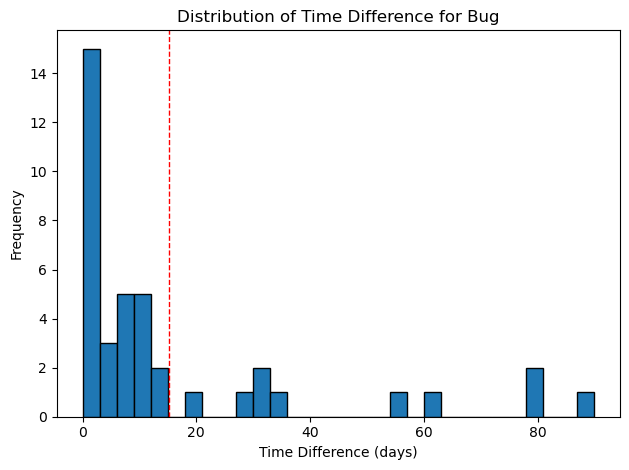

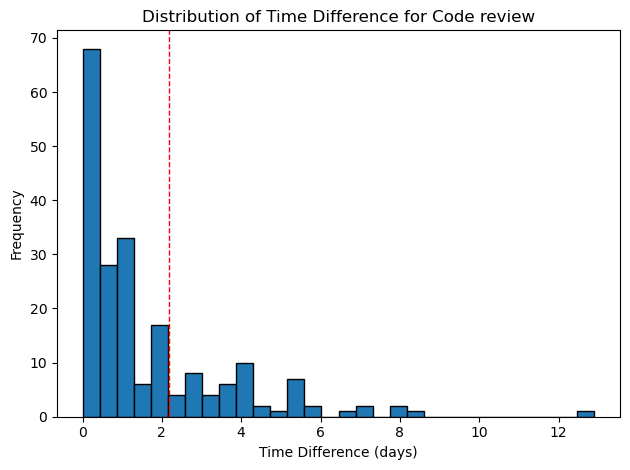

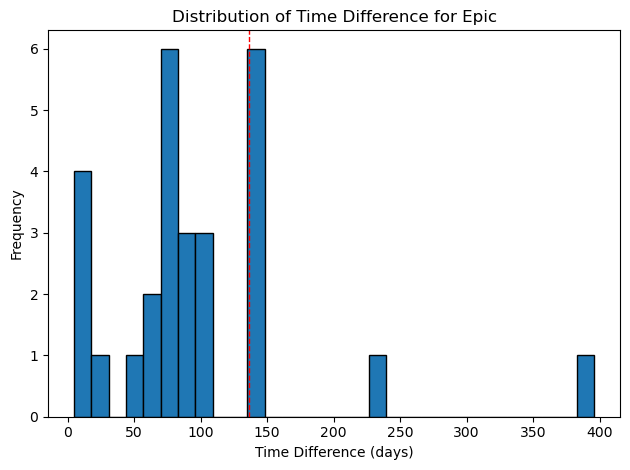

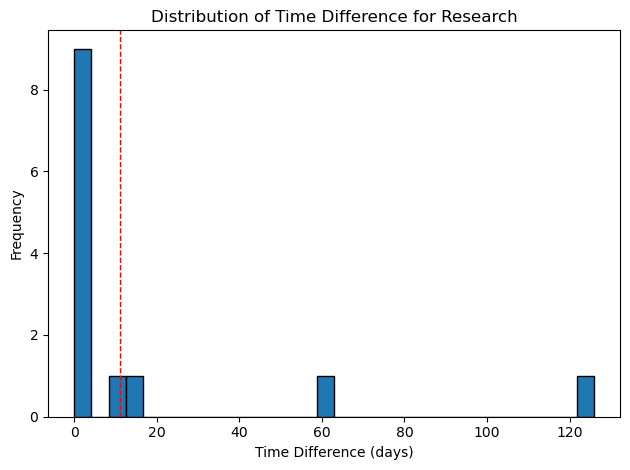

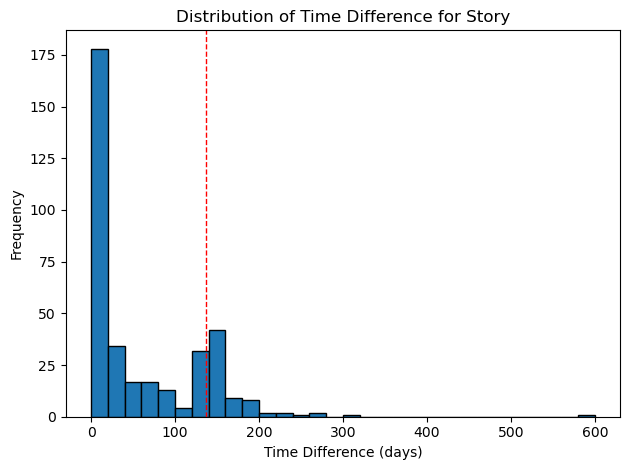

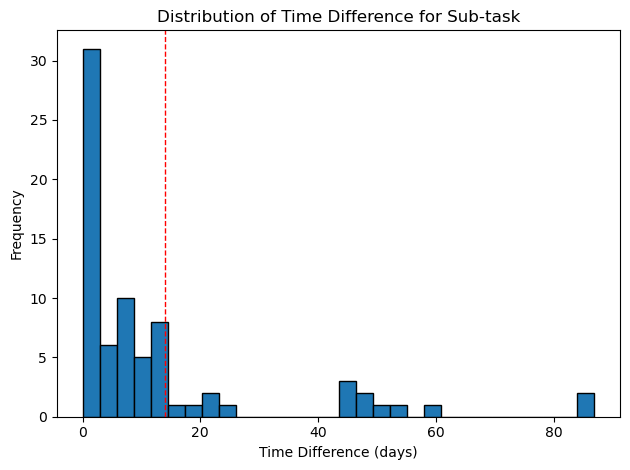

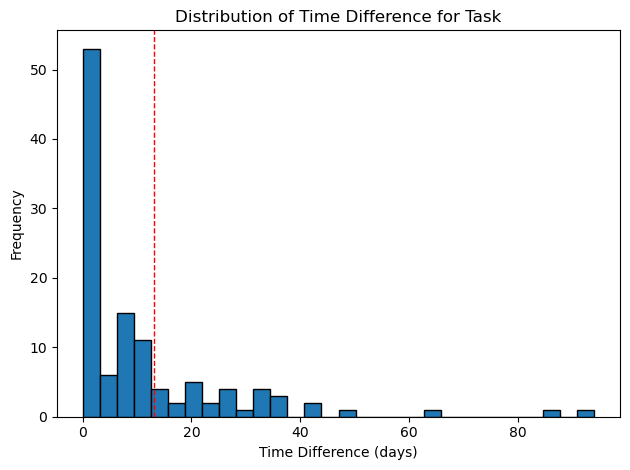

In [5]:
#plot the graphs 
import matplotlib.pyplot as plt

for name in stats_dict:
    time_diff = df[df['Issue Type'] == name]['Time Difference (days)']
    percentile_75 = stats_dict[name]['75th_percentile']
    plt.figure()
    plt.hist(time_diff, bins=30, edgecolor='black')
    plt.axvline(percentile_75, color='r', linestyle='dashed', linewidth=1)
    plt.title(f'Distribution of Time Difference for {name}')
    plt.xlabel('Time Difference (days)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'./{name}_distribution.png')

In [6]:
# further analysis of issue in tail
import pandas as pd
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('4.csv')

# Convert 'Resolved' and 'Created' columns to datetime format
df['Resolved'] = pd.to_datetime(df['Resolved'])
df['Created'] = pd.to_datetime(df['Created'])

# Calculate the difference between 'Resolved' and 'Created' in hours
df['Time Difference (hours)'] = (df['Resolved'] - df['Created']).dt.total_seconds() / 3600

# Group by 'Issue Type'
grouped = df.groupby('Issue Type')

# Initialize a dictionary to store the statistics
stats_dict = {}

# Calculate statistics for each group
for name, group in grouped:
    time_diff = group['Time Difference (hours)']
    stats_dict[name] = {
        '75th_percentile': np.percentile(time_diff, 75)
    }

# Initialize a variable to store the total number of issues
total_issues = 0

# Print Issue Keys starting from the 75th percentile for each 'Issue Type'
print("\nIssue keys from the 75th Percentile:\n")
for name in stats_dict:
    percentile_75 = stats_dict[name]['75th_percentile']
    filtered_df = df[(df['Issue Type'] == name) & (df['Time Difference (hours)'] >= percentile_75)]
    num_issues = filtered_df.shape[0]
    total_issues += num_issues
    print(f"Issue Type: {name}")
    print(filtered_df['Issue key'])  # Print the 'Issue key' column
    print(f"Number of issues: {num_issues}")  # Print the number of issues
    print("-------------------------")

# Print the total number of issues
print(f"Total number of issues starting from the 75th percentile: {total_issues}")


Issue keys from the 75th Percentile:

Issue Type: Bug
462    LR-7576
500    LR-3581
501    LR-5915
672    LR-4320
804    LR-9086
825    LR-1634
826    LR-7550
827    LR-9581
833    LR-5209
834    LR-8089
Name: Issue key, dtype: object
Number of issues: 10
-------------------------
Issue Type: Code review
10     LR-7243
13     LR-7738
17     LR-7608
23     LR-1419
24     LR-6289
28     LR-1786
44     LR-1702
59     LR-2015
75     LR-6523
84     LR-1300
90     LR-5126
122    LR-7534
124    LR-6634
145    LR-6837
159    LR-4268
166    LR-5423
193    LR-7930
209    LR-8847
213    LR-9691
219    LR-5656
221    LR-7183
227    LR-7872
233    LR-3862
246    LR-1633
248    LR-5295
251    LR-7643
255    LR-4124
260    LR-7276
288    LR-3576
352    LR-5279
419    LR-4425
424    LR-1533
431    LR-5024
432    LR-1905
443    LR-2470
447    LR-3225
448    LR-8607
449    LR-2365
450    LR-6124
465    LR-7305
466    LR-9014
497    LR-5847
504    LR-7076
529    LR-3971
534    LR-1363
578    LR-4177
580